<a href="https://colab.research.google.com/github/cavs1010/wetland_data_ana/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-posthocs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -q https://raw.githubusercontent.com/cavs1010/utils_wetland/main/utils.py -O utils.py
from utils import calculate_outliers

# 1. Cleaning Data set

In [ ]:
# Import the data set
df = pd.read_csv('/content/drive/MyDrive/🎓Uni/Data_analysis_wetlands/Resources/03_data_jup_Note.csv')

# Deleting empty rows
df = df.dropna(how='all')

# Create a dictionary with current column names as keys and new column names as values
new_column_names = {
    'Article ID(Wetland_id)': 'Wetland_ID',
    'Latitude (decimal)': 'Latitude',
    'Longitude (decimal)': 'Longitude',
    'Standardized Country': 'Country',
    'Standardized Equipment': 'Equipment',
    'Standardized Month': 'Month',
    'Standardized Year': 'Year',
    'Standardized Season': 'Season',
    'Standardized Vegetation in Chamber': 'Vegetation_Chamber',
    'Standardized Type of Vegetation': 'Type_of_Vegetation',
    'Standardized Inlet Source': 'Inlet_Source',
    'Standardized Substrate Type': 'Substrate_Type',
    'Standardized Operational Period (Years)': 'Operational_Period_Years',
    'Standardized GHG Type': 'GHG_Type',
    'Standardize Units': 'Units',
    'Standardized Flux Value': 'Flux_Value'
}

# Rename the columns
df.rename(columns=new_column_names, inplace=True)

# Convert specified columns to numeric types
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['Month'] = pd.to_numeric(df['Month'], errors='coerce')
df['Operational_Period_Years'] = pd.to_numeric(df['Operational_Period_Years'], errors='coerce')

# Create a new column 'CO2e' initialized to 0
df['CO2e'] = 0
# Convert CH4 emissions to CO2e and store in the new column
df.loc[df['GHG_Type'] == 'CH4', 'CO2e'] = df['Flux_Value'] * 25
# Convert N2O emissions to CO2e and store in the new column
df.loc[df['GHG_Type'] == 'N2O', 'CO2e'] = df['Flux_Value'] * 298
# CO2 emissions remain the same in terms of CO2e
df.loc[df['GHG_Type'] == 'CO2', 'CO2e'] = df['Flux_Value']

df.tail(5)

,Wetland_ID,Latitude,Longitude,Country,Equipment,Month,Year,Season,Vegetation_Chamber,Type_of_Vegetation,Inlet_Source,Substrate_Type,Operational_Period_Years,GHG_Type,Units,Flux_Value,CO2e
371,ar_61_typha,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,4.940,1472.120
372,ar_61_phragmites,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,CH4,mg CH4 m^-2 d^-1,333.000,8325.000
373,ar_61_phragmites,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,7.800,2324.400
374,ar_61_no_plants,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,No Plants,No Plants,River Water,Organic,10.0,CH4,mg CH4 m^-2 d^-1,-4.760,-119.000
375,ar_61_no_plants,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,No Plants,No Plants,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,-0.257,-76.586


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wetland_ID                376 non-null    object 
 1   Latitude                  364 non-null    float64
 2   Longitude                 364 non-null    float64
 3   Country                   376 non-null    object 
 4   Equipment                 376 non-null    object 
 5   Month                     346 non-null    float64
 6   Year                      376 non-null    int64  
 7   Season                    376 non-null    object 
 8   Vegetation_Chamber        376 non-null    object 
 9   Type_of_Vegetation        376 non-null    object 
 10  Inlet_Source              376 non-null    object 
 11  Substrate_Type            376 non-null    object 
 12  Operational_Period_Years  332 non-null    float64
 13  GHG_Type                  376 non-null    object 
 14  Units     

# 2. Data Analysis

## 2.1 Overview of GHG Emissions from Wetlands
In this section, we provide an initial analysis of the greenhouse gas (GHG) emissions data from wetlands. We will examine the general distribution of CO2, CH4, and N2O emissions, comparing their distributions and identifying any key patterns or outliers. This will set the stage for more detailed analyses in subsequent sections.

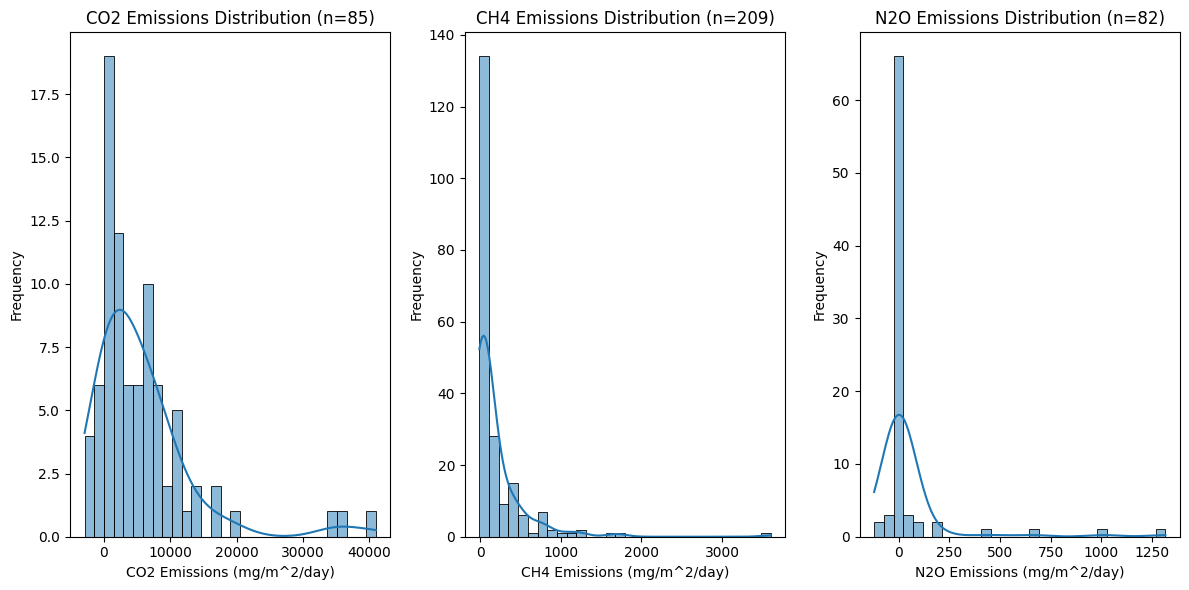

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for each GHG type
co2_data = df[df['GHG_Type'] == 'CO2']['Flux_Value']
ch4_data = df[df['GHG_Type'] == 'CH4']['Flux_Value']
n2o_data = df[df['GHG_Type'] == 'N2O']['Flux_Value']

# Calculate the counts for each GHG type
co2_count = co2_data.shape[0]
ch4_count = ch4_data.shape[0]
n2o_count = n2o_data.shape[0]

# Calculate the number of outliers for each GHG type
co2_outliers = calculate_outliers(df[df['GHG_Type'] == 'CO2']['Flux_Value'])
ch4_outliers = calculate_outliers(df[df['GHG_Type'] == 'CH4']['Flux_Value'])
n2o_outliers = calculate_outliers(df[df['GHG_Type'] == 'N2O']['Flux_Value'])

# Plot histograms
plt.figure(figsize=(12, 6))

# CO2
plt.subplot(1, 3, 1)
sns.histplot(co2_data, bins=30, kde=True)
plt.title(f'CO2 Emissions Distribution (n={co2_count})')
plt.xlabel('CO2 Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

# CH4
plt.subplot(1, 3, 2)
sns.histplot(ch4_data, bins=30, kde=True)
plt.title(f'CH4 Emissions Distribution (n={ch4_count})')
plt.xlabel('CH4 Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

# N2O
plt.subplot(1, 3, 3)
sns.histplot(n2o_data, bins=30, kde=True)
plt.title(f'N2O Emissions Distribution (n={n2o_count})')
plt.xlabel('N2O Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Insights from GHG Emissions Distribution

The histograms with KDE plots for CO2, CH4, and N2O emissions reveal that all three greenhouse gases exhibit a **right-skewed distribution**, indicating that most emissions are concentrated at the lower end of the scale, with a few extreme high values. **CO2 emissions** show a broad distribution with a majority of values below 10,000 mg/m^2/day, while **CH4 emissions** have a very high frequency of low values near zero, suggesting that CH4 emissions are generally low but can occasionally spike. **N2O emissions** are predominantly close to zero, with very few high emission instances. These patterns suggest that while **typical emissions are low**, certain conditions can lead to **significant emission spikes**.


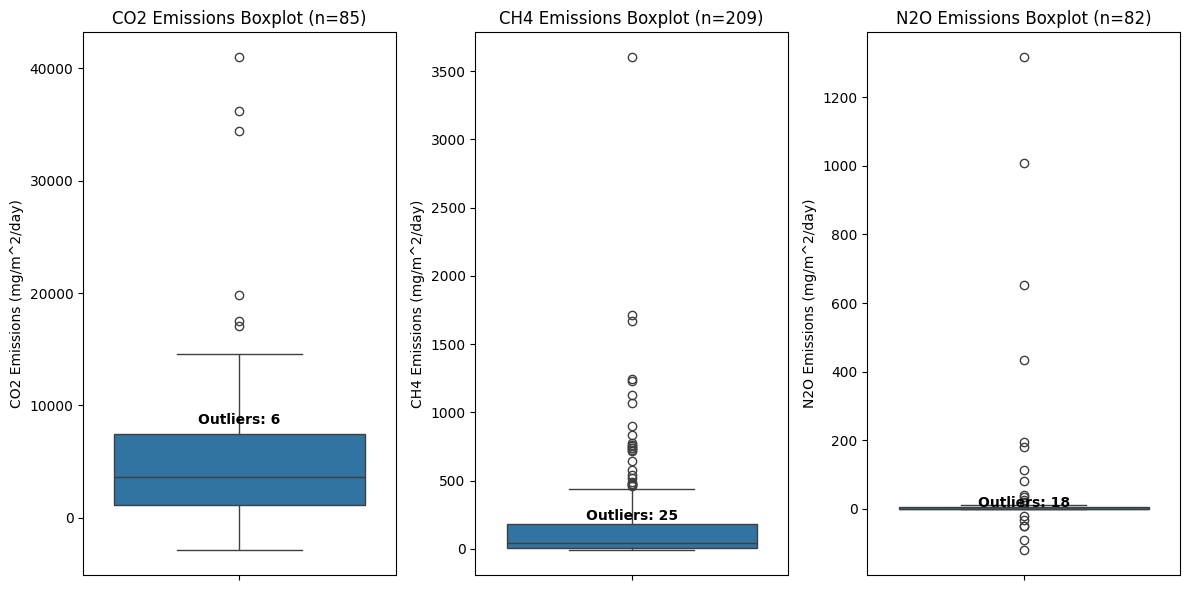

In [ ]:
# Create a boxplot for each GHG type to check for outliers
plt.figure(figsize=(12, 6))

# CO2
plt.subplot(1, 3, 1)
sns.boxplot(y=df[df['GHG_Type'] == 'CO2']['Flux_Value'])
plt.title(f'CO2 Emissions Boxplot (n={co2_count})')
plt.ylabel('CO2 Emissions (mg/m^2/day)')
plt.text(0, co2_data.quantile(0.75) + 1.5 * (co2_data.quantile(0.75) - co2_data.quantile(0.25)) * 0.1, f'Outliers: {co2_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

# CH4
plt.subplot(1, 3, 2)
sns.boxplot(y=df[df['GHG_Type'] == 'CH4']['Flux_Value'])
plt.title(f'CH4 Emissions Boxplot (n={ch4_count})')
plt.ylabel('CH4 Emissions (mg/m^2/day)')
plt.text(0, ch4_data.quantile(0.75) + 1.5 * (ch4_data.quantile(0.75) - ch4_data.quantile(0.25)) * 0.1, f'Outliers: {ch4_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

# N2O
plt.subplot(1, 3, 3)
sns.boxplot(y=df[df['GHG_Type'] == 'N2O']['Flux_Value'])
plt.title(f'N2O Emissions Boxplot (n={n2o_count})')
plt.ylabel('N2O Emissions (mg/m^2/day)')
plt.text(0, n2o_data.quantile(0.75) + 1.5 * (n2o_data.quantile(0.75) - n2o_data.quantile(0.25)) * 0.1, f'Outliers: {n2o_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.tight_layout()
plt.show()

### Insights from the Boxplots of GHG Emissions

The boxplots for CO2, CH4, and N2O emissions reveal valuable insights into the **distribution** and presence of **outliers**. CO2 emissions have 6 outliers, indicating occasional **spikes** in emissions, with most values concentrated below 10,000 mg/m^2/day. CH4 emissions display the highest variability with 23 outliers, suggesting frequent **high emission events** and a narrow IQR reflecting low central variability. N2O emissions, while generally low, exhibit 18 outliers, pointing to conditions that lead to **substantial increases**. These outliers across all GHGs suggest that specific environmental factors may cause significant deviations in emissions.


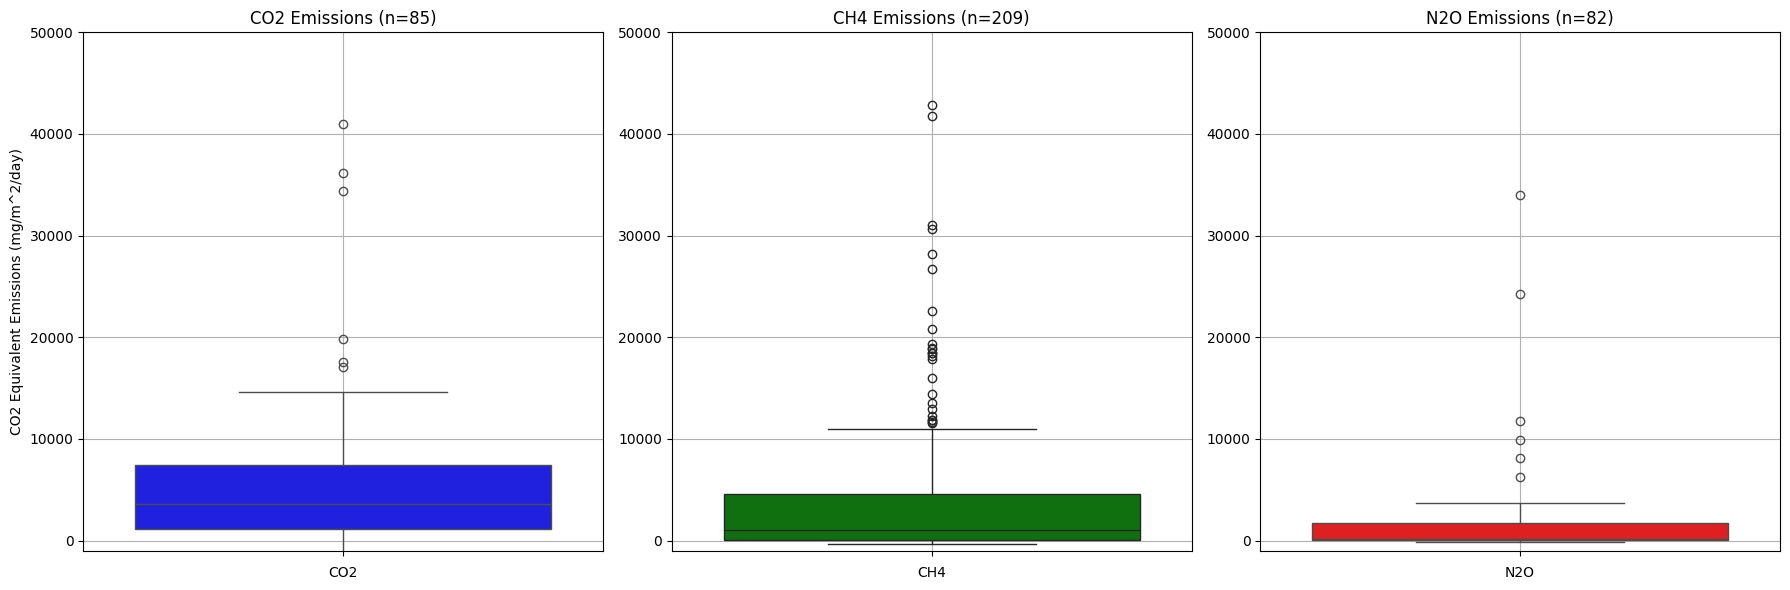

In [ ]:
# Set the figure size
plt.figure(figsize=(18, 6))

# Create a common y-axis for all subplots
y_lim = (-1000, 50000)

# CO2 Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(y=df[df['GHG_Type'] == 'CO2']['CO2e'], color='blue')
plt.title('CO2 Emissions (n={})'.format(df[df['GHG_Type'] == 'CO2'].shape[0]))
plt.ylabel('CO2 Equivalent Emissions (mg/m^2/day)')
plt.xlabel('CO2')
plt.ylim(y_lim)
plt.grid(True)

# CH4 Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=df[df['GHG_Type'] == 'CH4']['CO2e'], color='green')
plt.title('CH4 Emissions (n={})'.format(df[df['GHG_Type'] == 'CH4'].shape[0]))
plt.ylabel('')
plt.xlabel('CH4')
plt.ylim(y_lim)
plt.grid(True)

# N2O Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=df[df['GHG_Type'] == 'N2O']['CO2e'], color='red')
plt.title('N2O Emissions (n={})'.format(df[df['GHG_Type'] == 'N2O'].shape[0]))
plt.ylabel('')
plt.xlabel('N2O')
plt.ylim(y_lim)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Extract CO2e emissions for each GHG type
co2e_data = df[df['GHG_Type'] == 'CO2']['CO2e']
ch4e_data = df[df['GHG_Type'] == 'CH4']['CO2e']
n2oe_data = df[df['GHG_Type'] == 'N2O']['CO2e']

# Perform the Kruskal-Wallis H-test
stat, p = kruskal(co2e_data, ch4e_data, n2oe_data)

# Print the results
print('Kruskal-Wallis H-test:')
print('H-statistic:', stat)
print('p-value:', p)

# Interpret the results
alpha = 0.05
if p < alpha:
    print("There is a statistically significant difference between the CO2e emissions of the three GHG types.")
else:
    print("There is no statistically significant difference between the CO2e emissions of the three GHG types.")


Kruskal-Wallis H-test:
H-statistic: 22.68618419861595
p-value: 1.185107355286706e-05
There is a statistically significant difference between the CO2e emissions of the three GHG types.


In [ ]:
import scikit_posthocs as sp
import pandas as pd

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'CO2e': df['CO2e'],
    'GHG_Type': df['GHG_Type']
})

# Perform Dunn's test with Bonferroni correction
dunn_result = sp.posthoc_dunn(data, val_col='CO2e', group_col='GHG_Type', p_adjust='bonferroni')

# Print the results
print(dunn_result)


          CH4       CO2       N2O
CH4  1.000000  0.006715  0.025733
CO2  0.006715  1.000000  0.000006
N2O  0.025733  0.000006  1.000000


### Insights from the CO2 Equivalent Emissions Boxplots

The boxplots of CO2 equivalent (CO2e) emissions for CO2, CH4, and N2O provide several key insights. The **median CO2e emissions** for CO2, CH4, and N2O are visibly different, with CH4 and N2O having a lower median CO2e emission compared to CO2. The **interquartile range (IQR)** for CH4 and N2O is much narrower than for CO2, indicating that CO2 emissions have higher variability. All three GHGs show a significant number of outliers, with CO2 outliers reaching up to approximately 40,000 mg/m^2/day. CH4 and N2O also have several high-value outliers, but these are less extreme compared to CO2. The Dunn’s test results show statistically significant differences between the CO2e emissions of the three GHG types: **CH4 vs CO2** (p-value = 0.006715), **CH4 vs N2O** (p-value = 0.025733), and **CO2 vs N2O** (p-value = 0.000006). These p-values indicate that there are **significant differences** between the CO2e emissions for each pair of GHGs, with the most significant difference observed between CO2 and N2O. The CO2 equivalent (CO2e) emissions data demonstrates that **CO2 has the highest median emissions and the greatest variability**. The presence of numerous outliers across all three GHGs indicates that there are conditions under which emissions can spike dramatically. The statistical tests confirm that these differences in emissions are significant, suggesting that each GHG type behaves differently in terms of CO2e emissions. Given these insights, the next step involves exploring whether the **technique used to measure the gas** has any impact on the observed emissions. This analysis will help in understanding if measurement techniques contribute to the variability and differences observed in CO2e emissions across different GHG types.


In [ ]:
def calculate_outliers(data):
    """
    Calculate the number of outliers in a given data series using the IQR method.

    Parameters:
    data (pd.Series): The data series to analyze.

    Returns:
    int: The number of outliers in the data series.
    """
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return len(outliers)

def add_sample_and_outliers_text(ax, df, value_column, category_column):
    """
    Add sample size and outliers count annotations to a boxplot.

    Parameters:
    ax (matplotlib.axes.Axes): The Axes object to annotate.
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.
    """
    outlier_counts = df.groupby(category_column)[value_column].apply(calculate_outliers)
    sample_sizes = df[category_column].value_counts().sort_index()

    for i, category in enumerate(df[category_column].unique()):
        count = sample_sizes[category]
        outliers = outlier_counts[category]
        ax.text(i, df[value_column].max(), f'n={count}\nOutliers={outliers}',
                horizontalalignment='center', size='medium', color='black', weight='semibold')

def plot_boxplot(df, value_column, category_column, y_label, title_prefix):
    """
    Plot a boxplot with sample size and outliers count annotations.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.
    y_label (str): The label for the y-axis.
    title_prefix (str): The prefix for the plot title.
    """
    plt.figure(figsize=(15, 8))
    ax = sns.boxplot(x=category_column, y=value_column, data=df, palette="Set2")
    add_sample_and_outliers_text(ax, df, value_column, category_column)

    plt.title(f'{title_prefix} by {category_column}')
    plt.xlabel(category_column)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def perform_kruskal_wallis_test(df, value_column, category_column):
    """
    Perform the Kruskal-Wallis H test for independent samples.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.

    Returns:
    kruskal_result: The result of the Kruskal-Wallis H test.
    """
    groups = [df[df[category_column] == category][value_column] for category in df[category_column].unique()]
    kruskal_result = kruskal(*groups)
    print(f'Kruskal-Wallis H Test: Statistic={kruskal_result.statistic}, p-value={kruskal_result.pvalue}')
    return kruskal_result

def perform_posthoc_dunn_test(df, value_column, category_column):
    """
    Perform Dunn's post-hoc test for multiple comparisons after the Kruskal-Wallis test.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.

    Returns:
    dunn_result (pd.DataFrame): The result of Dunn's post-hoc test.
    """
    dunn_result = posthoc_dunn(df, val_col=value_column, group_col=category_column, p_adjust='bonferroni')
    print(f'Dunn\'s Test Results:\n{dunn_result}')
    return dunn_result

def create_boxplot_and_stats(df, value_column, category_column, y_label, title_prefix):
    """
    Create a boxplot and perform Kruskal-Wallis and Dunn's post-hoc tests.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.
    y_label (str): The label for the y-axis.
    title_prefix (str): The prefix for the plot title.

    Returns:
    dunn_result (pd.DataFrame or None): The result of Dunn's post-hoc test if significant differences are found.
    """
    plot_boxplot(df, value_column, category_column, y_label, title_prefix)
    kruskal_result = perform_kruskal_wallis_test(df, value_column, category_column)
    if kruskal_result.pvalue < 0.05:
        dunn_result = perform_posthoc_dunn_test(df, value_column, category_column)
        return dunn_result
    else:
        print("No significant difference found by Kruskal-Wallis test.")
        return None


## 2.2 Impact of Measurement Techniques on CO2, CH4 and N2O Emissions


In [ ]:
df['Equipment'].unique()

array(['Static Chambers', 'Eddy Covariance Systems', 'Polyethylene Bags',
       'Vials', 'Portable Gas Flux Systems', 'Floating Chambers',
       'Dynamic Chambers'], dtype=object)

In [ ]:
co2_data = df[df['GHG_Type'] == 'CO2']
ch4_data = df[df['GHG_Type'] == 'CH4']
n2o_data = df[df['GHG_Type'] == 'N2O']

<ipython-input-31-858f61db8325>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=category_column, y=value_column, data=df, palette="Set2")


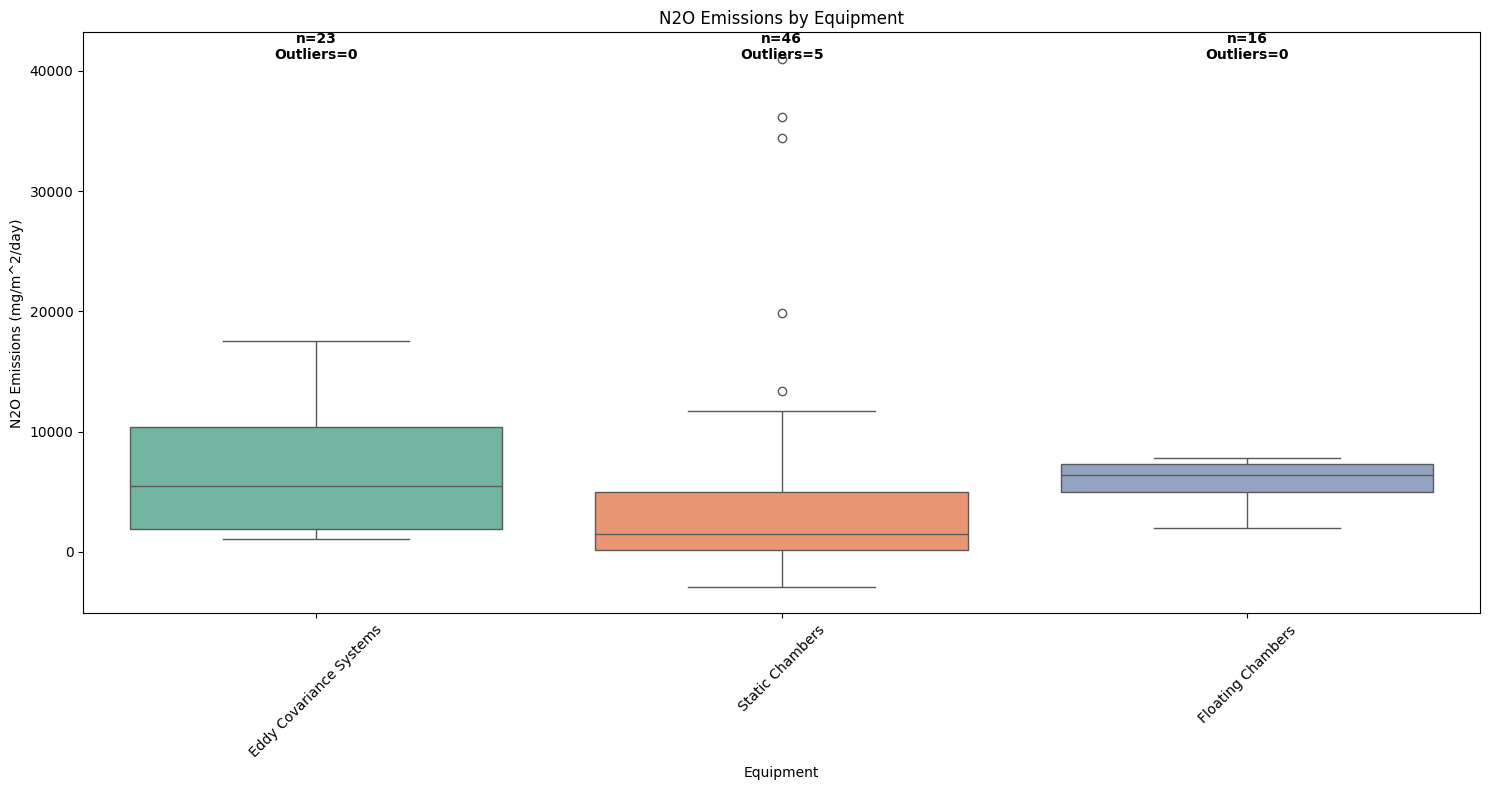

Kruskal-Wallis H Test: Statistic=12.461746701181099, p-value=0.0019677326255352107
Dunn's Test Results:
                         Eddy Covariance Systems  Floating Chambers  \
Eddy Covariance Systems                 1.000000           1.000000   
Floating Chambers                       1.000000           1.000000   
Static Chambers                         0.009892           0.018885   

                         Static Chambers  
Eddy Covariance Systems         0.009892  
Floating Chambers               0.018885  
Static Chambers                 1.000000  


,Eddy Covariance Systems,Floating Chambers,Static Chambers
Eddy Covariance Systems,1.000000,1.000000,0.009892
Floating Chambers,1.000000,1.000000,0.018885
Static Chambers,0.009892,0.018885,1.000000


In [ ]:
create_boxplot_and_stats(df = co2_data, value_column = 'Flux_Value', category_column = 'Equipment', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions')


### Insights from the CO2 Emissions Boxplot and Post-Hoc Results on Equipment
The analysis of CO2 emissions by measurement technique reveals several key insights. **Static Chambers** exhibit the highest variability and the most outliers, indicating a broad range of emission conditions, including extreme values. In contrast, **Eddy Covariance Systems** show moderate variability with a higher median CO2 emission, capturing more typical emission conditions without as many extremes. **Floating Chambers** display the least variability and lower median emissions, suggesting they might provide more consistent measurements but potentially underestimate higher emission events. Statistical analysis using Dunn's test indicates significant differences between Static Chambers and both Eddy Covariance Systems and Floating Chambers, but no significant difference between Eddy Covariance Systems and Floating Chambers. These findings highlight the importance of selecting appropriate measurement techniques for CO2 emission studies, as different methods can yield significantly different results. For the next section, it would be valuable to explore whether similar patterns hold for other greenhouse gases, such as CH4 and N2O, to see if the measurement technique consistently influences emissions across different gases.


<ipython-input-44-67d8f4b0fe4e>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=category_column, y=value_column, data=df, palette="Set2")


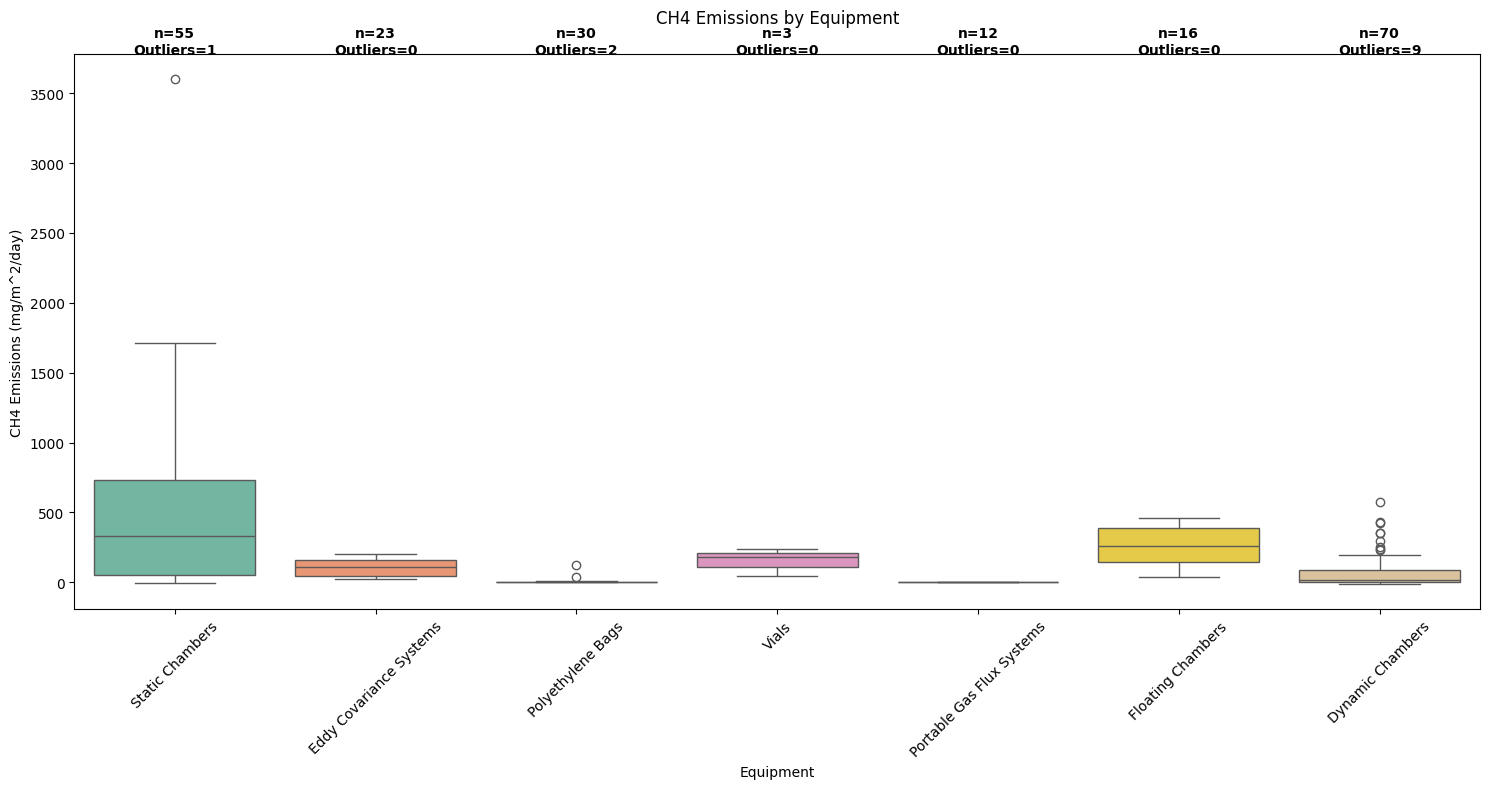

Kruskal-Wallis H Test: Statistic=100.73553081270208, p-value=1.7622735714635952e-19
Dunn's Test Results:
                           Dynamic Chambers  Eddy Covariance Systems  \
Dynamic Chambers               1.000000e+00                 0.084930   
Eddy Covariance Systems        8.492983e-02                 1.000000   
Floating Chambers              1.063773e-03                 1.000000   
Polyethylene Bags              2.734332e-02                 0.000011   
Portable Gas Flux Systems      1.883362e-02                 0.000025   
Static Chambers                4.657522e-07                 1.000000   
Vials                          1.000000e+00                 1.000000   

                           Floating Chambers  Polyethylene Bags  \
Dynamic Chambers                1.063773e-03       2.734332e-02   
Eddy Covariance Systems         1.000000e+00       1.058852e-05   
Floating Chambers               1.000000e+00       7.906611e-08   
Polyethylene Bags               7.906611e-08      

,Dynamic Chambers,Eddy Covariance Systems,Floating Chambers,Polyethylene Bags,Portable Gas Flux Systems,Static Chambers,Vials
Dynamic Chambers,1.000000e+00,0.084930,1.063773e-03,2.734332e-02,1.883362e-02,4.657522e-07,1.000000
Eddy Covariance Systems,8.492983e-02,1.000000,1.000000e+00,1.058852e-05,2.541158e-05,1.000000e+00,1.000000
Floating Chambers,1.063773e-03,1.000000,1.000000e+00,7.906611e-08,3.219959e-07,1.000000e+00,1.000000
Polyethylene Bags,2.734332e-02,0.000011,7.906611e-08,1.000000e+00,1.000000e+00,1.044572e-12,0.183608
Portable Gas Flux Systems,1.883362e-02,0.000025,3.219959e-07,1.000000e+00,1.000000e+00,2.855521e-09,0.060526
Static Chambers,4.657522e-07,1.000000,1.000000e+00,1.044572e-12,2.855521e-09,1.000000e+00,1.000000
Vials,1.000000e+00,1.000000,1.000000e+00,1.836085e-01,6.052644e-02,1.000000e+00,1.000000


In [ ]:
create_boxplot_and_stats(df = ch4_data, value_column = 'Flux_Value', category_column = 'Equipment', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions')

<ipython-input-59-8032ab4ace15>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=category_column, y=value_column, data=df, palette="Set2")


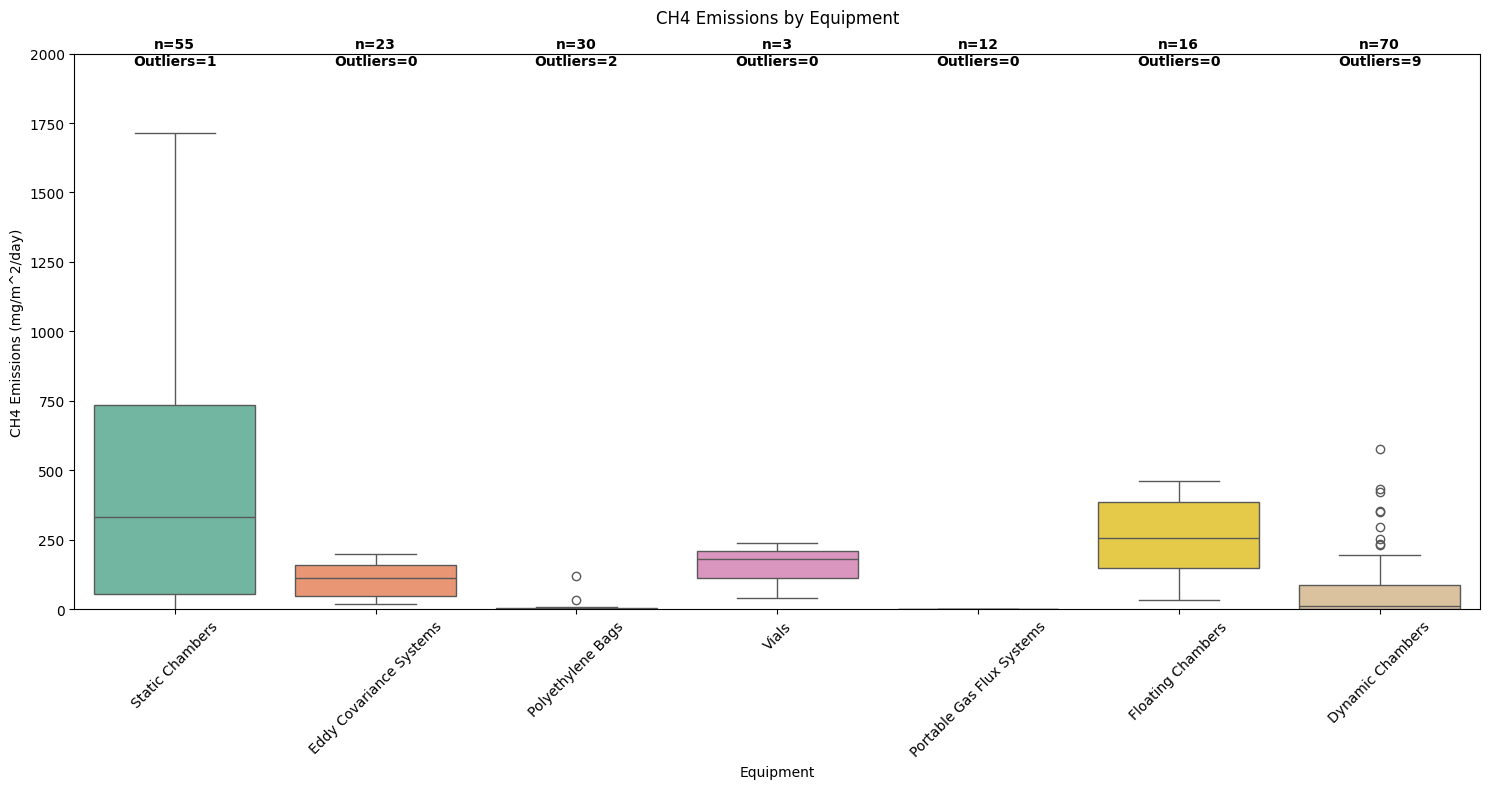

😔 Excluded from analysis due to small sample size: ['Vials']
Kruskal-Wallis H Test: Statistic=99.0994821128702, p-value=8.181377009511486e-20
Dunn's Test Results:



,Dynamic Chambers,Eddy Covariance Systems,Floating Chambers,Polyethylene Bags,Portable Gas Flux Systems,Static Chambers
Dynamic Chambers,1.000000,0.005210,0.000109,0.001917,0.001403,0.000000
Eddy Covariance Systems,0.005210,1.000000,0.247492,0.000001,0.000002,0.252598
Floating Chambers,0.000109,0.247492,1.000000,0.000000,0.000000,0.688718
Polyethylene Bags,0.001917,0.000001,0.000000,1.000000,0.341957,0.000000
Portable Gas Flux Systems,0.001403,0.000002,0.000000,0.341957,1.000000,0.000000
Static Chambers,0.000000,0.252598,0.688718,0.000000,0.000000,1.000000


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

def calculate_outliers(data):
    """
    Calculate the number of outliers in a given data series using the IQR method.

    Parameters:
    data (pd.Series): The data series to analyze.

    Returns:
    int: The number of outliers in the data series.
    """
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return len(outliers)

def add_sample_and_outliers_text(ax, df, value_column, category_column):
    """
    Add sample size and outliers count annotations to a boxplot.

    Parameters:
    ax (matplotlib.axes.Axes): The Axes object to annotate.
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.
    """
    outlier_counts = df.groupby(category_column)[value_column].apply(calculate_outliers)
    sample_sizes = df[category_column].value_counts().sort_index()

    offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.02  # 2% of the y-axis range for spacing

    for i, category in enumerate(df[category_column].unique()):
        count = sample_sizes[category]
        outliers = outlier_counts[category]
        ax.text(i, df[value_column].max() if ax.get_ylim()[1] is None else ax.get_ylim()[1] - offset,
                f'n={count}\nOutliers={outliers}',
                horizontalalignment='center', size='medium', color='black', weight='semibold')

def plot_boxplot(df, value_column, category_column, y_label, title_prefix, y_limits=None):
    """
    Plot a boxplot with sample size and outliers count annotations.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.
    y_label (str): The label for the y-axis.
    title_prefix (str): The prefix for the plot title.
    y_limits (tuple): Optional. The limits for the y-axis in the format (y_min, y_max).
    """
    plt.figure(figsize=(15, 8))
    ax = sns.boxplot(x=category_column, y=value_column, data=df, palette="Set2")
    if y_limits is not None:
        ax.set_ylim(y_limits)
    add_sample_and_outliers_text(ax, df, value_column, category_column)

    plt.title(f'{title_prefix} by {category_column}', pad=22)
    plt.xlabel(category_column)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def perform_kruskal_wallis_test(df, value_column, category_column, min_sample_size):
    """
    Perform the Kruskal-Wallis H test for independent samples, excluding groups with sample size below a threshold.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.
    min_sample_size (int): The minimum sample size required to include a group in the analysis.

    Returns:
    kruskal_result: The result of the Kruskal-Wallis H test.
    """
    valid_groups = [category for category in df[category_column].unique() if len(df[df[category_column] == category]) >= min_sample_size]
    excluded_groups = [category for category in df[category_column].unique() if len(df[df[category_column] == category]) < min_sample_size]
    groups = [df[df[category_column] == category][value_column] for category in valid_groups]

    if excluded_groups:
        print(f'😔 Excluded from analysis due to small sample size: {excluded_groups}')

    kruskal_result = kruskal(*groups)
    print(f'Kruskal-Wallis H Test: Statistic={kruskal_result.statistic}, p-value={kruskal_result.pvalue}')
    return kruskal_result

def perform_posthoc_dunn_test(df, value_column, category_column, min_sample_size):
    """
    Perform Dunn's post-hoc test for multiple comparisons after the Kruskal-Wallis test, excluding groups with sample size below a threshold.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.
    min_sample_size (int): The minimum sample size required to include a group in the analysis.

    Returns:
    dunn_result (pd.DataFrame): The result of Dunn's post-hoc test.
    """
    valid_df = df[df[category_column].isin([category for category in df[category_column].unique() if len(df[df[category_column] == category]) >= min_sample_size])]
    dunn_result = posthoc_dunn(valid_df, val_col=value_column, group_col=category_column, p_adjust='fdr_bh')
    print(f'Dunn\'s Test Results:\n')
    return dunn_result

def create_boxplot_and_stats(df, value_column, category_column, y_label, title_prefix, y_limits=None, min_sample_size=1):
    """
    Create a boxplot and perform Kruskal-Wallis and Dunn's post-hoc tests, excluding groups with sample size below a threshold.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_column (str): The name of the column containing the values.
    category_column (str): The name of the column containing the categories.
    y_label (str): The label for the y-axis.
    title_prefix (str): The prefix for the plot title.
    y_limits (tuple): Optional. The limits for the y-axis in the format (y_min, y_max).
    min_sample_size (int): The minimum sample size required to include a group in the analysis.

    Returns:
    dunn_result (pd.DataFrame or None): The result of Dunn's post-hoc test if significant differences are found.
    """
    plot_boxplot(df, value_column, category_column, y_label, title_prefix, y_limits)
    kruskal_result = perform_kruskal_wallis_test(df, value_column, category_column, min_sample_size)
    if kruskal_result.pvalue < 0.05:
        dunn_result = perform_posthoc_dunn_test(df, value_column, category_column, min_sample_size)

        # Highlighting p-values less than 0.05
        dunn_result_styled = dunn_result.style.applymap(lambda val: 'background-color: blue' if val < 0.05 else '')
        display(dunn_result_styled)

    else:
        print("No significant difference found by Kruskal-Wallis test.")
        return None

# Example call with y-limits and minimum sample size
create_boxplot_and_stats(df=ch4_data, value_column='Flux_Value', category_column='Equipment', y_label='CH4 Emissions (mg/m^2/day)', title_prefix='CH4 Emissions', y_limits=(0, 2000), min_sample_size=5)
